In [35]:
# Reload external modules if needed (useful during development)
%load_ext autoreload
%autoreload 2

## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
import torchinfo
import sklearn
from dataclasses import dataclass
from typing import Literal, Dict, Any
from utils import show_prediction,fast_gradient_sign_method, save_adversarial_images, get_resnet_blocks

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device cpu


In [ ]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

In [64]:
ModelName = Literal["resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]

@dataclass
class ModelConfig:
    model_name: ModelName = "resnet34"
    pretrained: bool = True

    def build(self, device: torch.device = device) -> torchvision.models.ResNet:
        """Construct and return the requested torchvision ResNet on the given device."""
        builders: Dict[ModelName, callable] = {
            "resnet18": torchvision.models.resnet18,
            "resnet34": torchvision.models.resnet34,
            "resnet50": torchvision.models.resnet50,
            "resnet101": torchvision.models.resnet101,
            "resnet152": torchvision.models.resnet152,
        }
        # For newer torchvision versions use weights enum; this example uses the simple API
        model = builders[self.model_name](weights='IMAGENET1K_V1' if self.pretrained else None)
        model = model.to(device)
        model.eval()
        return model

AttackName = Literal["fgsm"]

@dataclass
class AttackConfig:
    attack: AttackName = "fgsm"
    epsilon: float = 0.02

@dataclass
class ProbesConfig:
    learning_rate: float
    num_epochs: int

ADV_EXAMPLES_BASE = "../adv_examples"
ADV_EXAMPLES_DIR = os.path.join(ADV_EXAMPLES_BASE, ModelConfig.model_name)

NORMAL_ACTIVATIONS_BASE = os.path.join("./normal_activations/", ModelConfig.model_name)
NORMAL_ACTIVATIONS_PATH = os.path.join(NORMAL_ACTIVATIONS_BASE, "activations.pth")

ADV_ACTIVATIONS_BASE = os.path.join("./adv_activations/", ModelConfig.model_name)
ADV_ACTIVATIONS_PATH = os.path.join(ADV_ACTIVATIONS_BASE, "adv_activations.pth")

PROBES_DIR = os.path.join("./probes", AttackConfig.attack, ModelConfig.model_name)

#make dirs if they don't exist
os.makedirs(ADV_EXAMPLES_DIR, exist_ok=True)
os.makedirs(NORMAL_ACTIVATIONS_BASE, exist_ok=True)
os.makedirs(ADV_ACTIVATIONS_BASE, exist_ok=True)
os.makedirs(PROBES_DIR, exist_ok=True)

In [4]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = ModelConfig().build().to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:07<00:00, 11.0MB/s]


In [5]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)
    
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [6]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
# for i in range(1,17,5):
#     show_prediction(exmp_batch[i], label_batch[i], preds[i])

In [7]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

In [ ]:
# _ = eval_model(data_loader, img_func=lambda x, y: fast_gradient_sign_method(pretrained_model, x, y, epsilon=0.02)[0])

In [8]:
# Generate adversarial examples for the entire dataset using FGSM and store them in a list
if not os.path.exists(ADV_EXAMPLES_DIR):
    adv_examples = []
    labels_list = []
    pretrained_model.eval()  # Ensure model is in eval mode

    for imgs, labels in tqdm(data_loader, desc="Generating adversarial examples..."):
        adv_imgs, _ = fast_gradient_sign_method(pretrained_model, imgs, labels, epsilon=0.02)
        adv_examples.extend(adv_imgs.cpu())
        labels_list.extend(labels.cpu())

    # Save adversarial examples
    save_adversarial_images(adv_examples, labels_list, ADV_EXAMPLES_DIR)
    adv_examples_dataset = torchvision.datasets.ImageFolder(ADV_EXAMPLES_DIR, transform= plain_transforms)

else:
    adv_examples_dataset = torchvision.datasets.ImageFolder(ADV_EXAMPLES_DIR, transform= plain_transforms)

Generating adversarial examples...: 100%|██████████| 157/157 [06:57<00:00,  2.66s/it]


In [10]:
adv_dataloader = data.DataLoader(adv_examples_dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)
exmp_adv_batch, label = next(iter(adv_dataloader))
with torch.no_grad():
    preds_adv = pretrained_model(exmp_adv_batch.to(device))

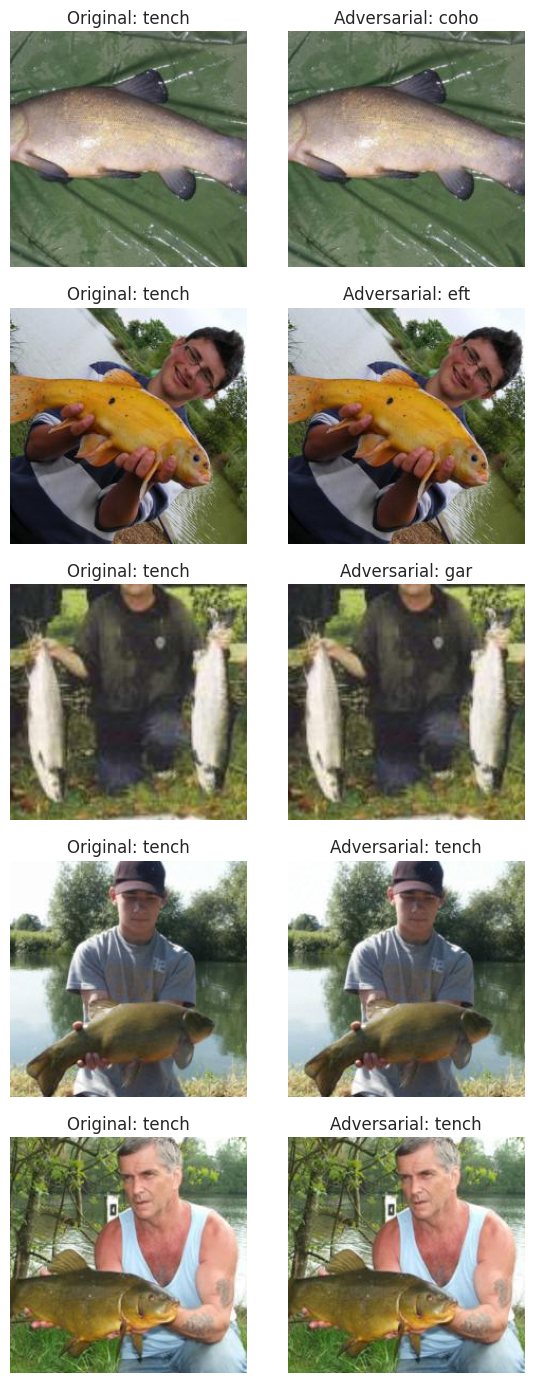

In [11]:
# Plot the first 5 original and adversarial images side by side

fig, axes = plt.subplots(5, 2, figsize=(6, 14))
for i in range(5):
    # Original image
    img = exmp_batch[i].cpu().permute(1, 2, 0).numpy()
    img = (img * NORM_STD[None, None]) + NORM_MEAN[None, None]
    img = np.clip(img, 0, 1)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Original: {label_names[label_batch[i]]}")
    axes[i, 0].axis('off')
    
    # Adversarial image (display)
    adv_img_disp = exmp_adv_batch[i].cpu().permute(1, 2, 0).numpy()
    adv_img_disp = (adv_img_disp * NORM_STD[None, None]) + NORM_MEAN[None, None]
    adv_img_disp = np.clip(adv_img_disp, 0, 1)
    axes[i, 1].imshow(adv_img_disp)

    # Get model prediction for this adversarial image and use it in the title
    with torch.no_grad():
        inp = exmp_adv_batch[i].unsqueeze(0).to(device)  # shape (1,3,224,224)
        preds = pretrained_model(inp)
        pred_idx = preds.argmax(dim=-1).item()
    axes[i, 1].set_title(f"Adversarial: {label_names[pred_idx]}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Hooks to get activations

In [14]:
torchinfo.summary(pretrained_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

In [36]:
layers_to_probe = get_resnet_blocks(pretrained_model)

In [38]:
layers_to_probe

{'layer1.0': BasicBlock(
   (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 'layer1.1': BasicBlock(
   (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 'layer1.2': BasicBlock(
   (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

In [39]:
activations = {}

def get_activation(name):
    """Creates a hook function to capture the output of a layer."""
    def hook(model, input, output):
        # Detach from the computation graph and move to CPU
        # Average over spatial dimensions (-1, -2) if output is 4D (batch, channels, H, W)
        if output.dim() == 4:
            activations[name] = output.detach().cpu().mean(dim=(-1, -2))
        else:
            activations[name] = output.detach().cpu()
    return hook


# Register a forward hook for each layer we want to probe
for name, layer in layers_to_probe.items():
    layer.register_forward_hook(get_activation(name))

In [40]:
# Run inference on a batch of normal images and collect activations
activations_total = {}
for exmp_batch, _ in tqdm(data_loader):
    activations = {}
    with torch.no_grad():
        _ = pretrained_model(exmp_batch.to(device))
    for name, module in layers_to_probe.items():
        if name in activations_total:
            activations_total[name] = torch.cat((activations_total[name], activations[name]), dim=0)
        else:
            activations_total[name] = activations[name]

100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


In [41]:
#save activations_total dictionary
torch.save(activations_total, NORMAL_ACTIVATIONS_PATH)

In [42]:
normal_activations = torch.load(NORMAL_ACTIVATIONS_PATH)

In [45]:
for layer_name, act in normal_activations.items():
    print(f"{layer_name}: shape={act.shape}")

layer1.0: shape=torch.Size([5000, 64])
layer1.1: shape=torch.Size([5000, 64])
layer1.2: shape=torch.Size([5000, 64])
layer2.0: shape=torch.Size([5000, 128])
layer2.1: shape=torch.Size([5000, 128])
layer2.2: shape=torch.Size([5000, 128])
layer2.3: shape=torch.Size([5000, 128])
layer3.0: shape=torch.Size([5000, 256])
layer3.1: shape=torch.Size([5000, 256])
layer3.2: shape=torch.Size([5000, 256])
layer3.3: shape=torch.Size([5000, 256])
layer3.4: shape=torch.Size([5000, 256])
layer3.5: shape=torch.Size([5000, 256])
layer4.0: shape=torch.Size([5000, 512])
layer4.1: shape=torch.Size([5000, 512])
layer4.2: shape=torch.Size([5000, 512])


In [46]:
adv_activ_total = {}
for exmp_batch, _ in tqdm(adv_dataloader):
    activations = {}
    with torch.no_grad():
        _ = pretrained_model(exmp_batch.to(device))
    for name, module in layers_to_probe.items():
        if name in adv_activ_total:
            adv_activ_total[name] = torch.cat((adv_activ_total[name], activations[name]), dim=0)
        else:
            adv_activ_total[name] = activations[name]

100%|██████████| 157/157 [03:46<00:00,  1.44s/it]


In [47]:
torch.save(adv_activ_total, ADV_ACTIVATIONS_PATH)

In [48]:
adv_activ_total = torch.load(ADV_ACTIVATIONS_PATH)

In [49]:
from sklearn.model_selection import train_test_split

# Get the number of samples (assume all layers have the same number of samples)
num_samples = next(iter(normal_activations.values())).shape[0]
indices = np.arange(num_samples)

# Split indices for train/test (same split for all layers)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

# Create train/test splits for each layer
normal_train = {layer: acts[train_idx] for layer, acts in normal_activations.items()}
normal_test = {layer: acts[test_idx] for layer, acts in normal_activations.items()}
adv_train = {layer: acts[train_idx] for layer, acts in adv_activ_total.items()}
adv_test = {layer: acts[test_idx] for layer, acts in adv_activ_total.items()}

In [50]:
from torch.utils.data import TensorDataset

probe_datasets = {}

for layer in normal_activations.keys():
    # Get activations for normal and adversarial samples (train and test splits)
    normal_train_acts = normal_train[layer]
    adv_train_acts = adv_train[layer]
    normal_test_acts = normal_test[layer]
    adv_test_acts = adv_test[layer]

    # Concatenate activations for train and test
    X_train = torch.cat([normal_train_acts, adv_train_acts], dim=0)
    y_train = torch.cat([
        torch.zeros(normal_train_acts.shape[0], dtype=torch.long),
        torch.ones(adv_train_acts.shape[0], dtype=torch.long)
    ], dim=0)

    X_test = torch.cat([normal_test_acts, adv_test_acts], dim=0)
    y_test = torch.cat([
        torch.zeros(normal_test_acts.shape[0], dtype=torch.long),
        torch.ones(adv_test_acts.shape[0], dtype=torch.long)
    ], dim=0)

    # Store as tuple of TensorDatasets for train and test
    probe_datasets[layer] = {
        'train': TensorDataset(X_train, y_train),
        'test': TensorDataset(X_test, y_test)
    }

In [51]:
probe_datasets

{'layer1.0': {'train': <torch.utils.data.dataset.TensorDataset at 0x7febef3abb30>,
  'test': <torch.utils.data.dataset.TensorDataset at 0x7feac3d45a30>},
 'layer1.1': {'train': <torch.utils.data.dataset.TensorDataset at 0x7febeda86c60>,
  'test': <torch.utils.data.dataset.TensorDataset at 0x7febeda810a0>},
 'layer1.2': {'train': <torch.utils.data.dataset.TensorDataset at 0x7feac3aed4f0>,
  'test': <torch.utils.data.dataset.TensorDataset at 0x7febef2eb4a0>},
 'layer2.0': {'train': <torch.utils.data.dataset.TensorDataset at 0x7febef3109e0>,
  'test': <torch.utils.data.dataset.TensorDataset at 0x7febef311700>},
 'layer2.1': {'train': <torch.utils.data.dataset.TensorDataset at 0x7febef3121b0>,
  'test': <torch.utils.data.dataset.TensorDataset at 0x7febedb19430>},
 'layer2.2': {'train': <torch.utils.data.dataset.TensorDataset at 0x7febedb198e0>,
  'test': <torch.utils.data.dataset.TensorDataset at 0x7febedb19be0>},
 'layer2.3': {'train': <torch.utils.data.dataset.TensorDataset at 0x7febedb1

In [52]:
# Define linear probes for each layer with the corresponding input sizes
class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.linear(x)

probe_input_dims = {layer: acts.shape[1] for layer, acts in normal_activations.items()}

linear_probes = {
    layer: LinearProbe(input_dim)
    for layer, input_dim in probe_input_dims.items()
}

In [57]:
from torch.utils.data import DataLoader

# Prepare dataloaders for layer1 probe
batch_size = 128
train_loader = DataLoader(probe_datasets['layer1.0']['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(probe_datasets['layer1.0']['test'], batch_size=batch_size, shuffle=False)

# Get the linear probe for layer1
probe = linear_probes['layer1.0'].to(device)

# Optimizer and loss
optimizer = optim.Adam(probe.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [58]:
num_epochs = 10
probe.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = probe(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    avg_loss = total_loss / total
    acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {acc:.4f}")

Epoch 1/10 - Loss: 0.7044 - Accuracy: 0.4879
Epoch 2/10 - Loss: 0.6949 - Accuracy: 0.4955
Epoch 3/10 - Loss: 0.6942 - Accuracy: 0.4983
Epoch 4/10 - Loss: 0.6939 - Accuracy: 0.4944
Epoch 5/10 - Loss: 0.6928 - Accuracy: 0.5081
Epoch 6/10 - Loss: 0.6924 - Accuracy: 0.5160
Epoch 7/10 - Loss: 0.6919 - Accuracy: 0.5179
Epoch 8/10 - Loss: 0.6907 - Accuracy: 0.5527
Epoch 9/10 - Loss: 0.6907 - Accuracy: 0.5423
Epoch 10/10 - Loss: 0.6911 - Accuracy: 0.5179


In [ ]:
# Train a linear probe for each layer and store results
probe_results = {}

num_epochs = 20
for layer, probe in linear_probes.items():
    print(f"\nTraining probe for {layer}...")
    probe = probe.to(device)
    optimizer = optim.Adam(probe.parameters(), lr=1e-2)
    criterion = nn.CrossEntropyLoss()
    train_loader = torch.utils.data.DataLoader(probe_datasets[layer]['train'], batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(probe_datasets[layer]['test'], batch_size=128, shuffle=False)

    # Training loop
    for epoch in range(num_epochs):
        probe.train()
        total_loss = 0.0
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = probe(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = total_loss / total
        acc = correct / total
        print(f"  Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {acc:.4f}")

    # Evaluate on test set
    probe.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = probe(X_batch)
            _, predicted = outputs.max(1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    test_acc = correct / total
    print(f"Test accuracy for {layer}: {test_acc:.4f}")
    probe_results[layer] = test_acc
    # Save the trained probe for this layer
    torch.save(probe.state_dict(), os.path.join(PROBES_DIR, f"{layer}.pth"))


Training probe for layer1.0...
  Epoch 1/20 - Loss: 0.7007 - Accuracy: 0.5326
  Epoch 2/20 - Loss: 0.6861 - Accuracy: 0.5427
  Epoch 3/20 - Loss: 0.6851 - Accuracy: 0.5514
  Epoch 4/20 - Loss: 0.6810 - Accuracy: 0.5825
  Epoch 5/20 - Loss: 0.6806 - Accuracy: 0.5769
  Epoch 6/20 - Loss: 0.6857 - Accuracy: 0.5564
  Epoch 7/20 - Loss: 0.6764 - Accuracy: 0.5729
  Epoch 8/20 - Loss: 0.6734 - Accuracy: 0.5982
  Epoch 9/20 - Loss: 0.6733 - Accuracy: 0.5876
  Epoch 10/20 - Loss: 0.6701 - Accuracy: 0.5990
  Epoch 11/20 - Loss: 0.6688 - Accuracy: 0.6035
  Epoch 12/20 - Loss: 0.6741 - Accuracy: 0.5757
  Epoch 13/20 - Loss: 0.6684 - Accuracy: 0.6021
  Epoch 14/20 - Loss: 0.6648 - Accuracy: 0.6064
  Epoch 15/20 - Loss: 0.6632 - Accuracy: 0.6265
  Epoch 16/20 - Loss: 0.6601 - Accuracy: 0.6365
  Epoch 17/20 - Loss: 0.6628 - Accuracy: 0.6198
  Epoch 18/20 - Loss: 0.6618 - Accuracy: 0.6250
  Epoch 19/20 - Loss: 0.6567 - Accuracy: 0.6416
  Epoch 20/20 - Loss: 0.6591 - Accuracy: 0.6256
Test accuracy for

In [60]:
probe_results

{'layer1.0': 0.57,
 'layer1.1': 0.735,
 'layer1.2': 0.7285,
 'layer2.0': 0.784,
 'layer2.1': 0.796,
 'layer2.2': 0.78,
 'layer2.3': 0.7795,
 'layer3.0': 0.781,
 'layer3.1': 0.7645,
 'layer3.2': 0.741,
 'layer3.3': 0.7485,
 'layer3.4': 0.7115,
 'layer3.5': 0.733,
 'layer4.0': 0.708,
 'layer4.1': 0.689,
 'layer4.2': 0.6255}

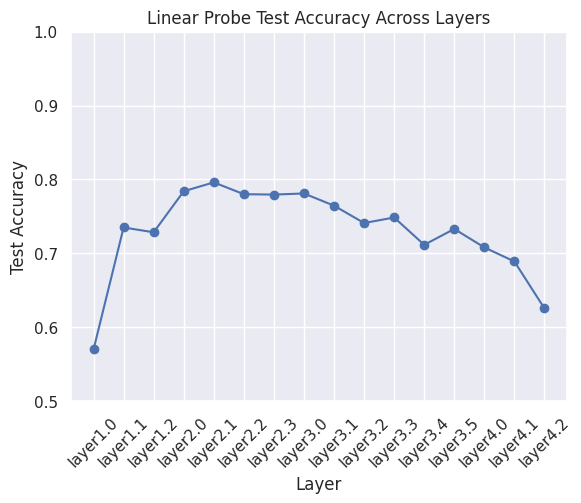

In [63]:
# Plot probe test accuracy across layers
layer_names = list(probe_results.keys())
accuracies = [probe_results[layer] for layer in layer_names]

plt.figure()
plt.plot(layer_names, accuracies, marker='o')
plt.ylabel('Test Accuracy')
plt.xlabel('Layer')
plt.title('Linear Probe Test Accuracy Across Layers')
plt.ylim(0.5, 1)
plt.xticks(rotation=45)
plt.show()